In [11]:
import numpy as np
from cifar import load_cifar10
X_train,y_train,X_val,y_val,X_test,y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print X_train.shape,y_train.shape

(40000, 3, 32, 32) (40000,)


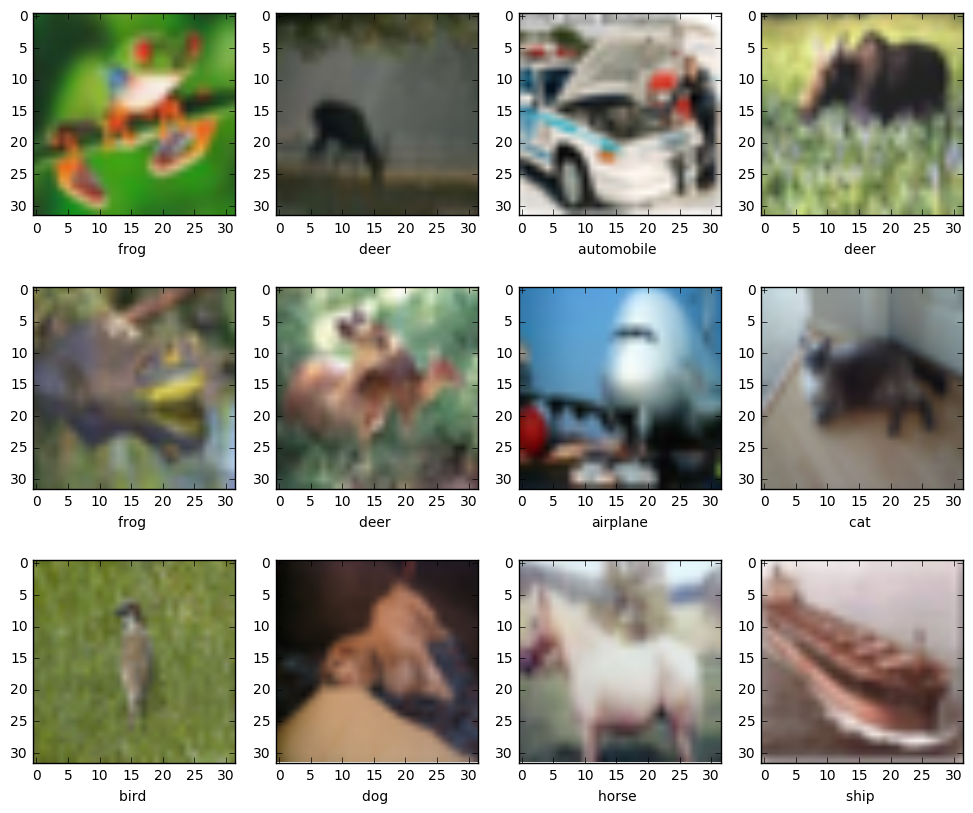

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

In [1]:
import lasagne
import theano
import theano.tensor as T

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


Defining network architecture

In [14]:
#Input layer (auxilary)
input_layer = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)

#fully connected layer, that takes input layer and applies 50 neurons to it.
# nonlinearity here is sigmoid as in logistic regression
# you can give a name to each layer (optional)
dense_1 = lasagne.layers.DenseLayer(input_layer,num_units=100,
                                   nonlinearity = lasagne.nonlinearities.sigmoid,
                                   name = "hidden_dense_layer")

#fully connected output layer that takes dense_1 as input and has 10 neurons (1 for each digit)
#We use softmax nonlinearity to make probabilities add up to 1
dense_output = lasagne.layers.DenseLayer(dense_1,num_units = 10,
                                        nonlinearity = lasagne.nonlinearities.softmax,
                                        name='output')


In [15]:
#network prediction (theano-transformation)
y_predicted = lasagne.layers.get_output(dense_output)

In [16]:
#all network weights (shared variables)
all_weights = lasagne.layers.get_all_params(dense_output,trainable=True)
print all_weights

[hidden_dense_layer.W, hidden_dense_layer.b, output.W, output.b]


In [17]:
#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

#prediction accuracy
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.sgd(loss, all_weights,learning_rate=0.01)

In [18]:
#function that computes loss and updates weights
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

In [19]:
#deterministic prediciton (without dropout)
y_predicted_det = lasagne.layers.get_output(dense_output,deterministic=True)

#prediction accuracy (without dropout)
accuracy_det = lasagne.objectives.categorical_accuracy(y_predicted_det,target_y).mean()

#function that just computes accuracy without dropout/noize -- for evaluation purposes
accuracy_fun = theano.function([input_X,target_y],accuracy_det)

In [11]:
def iterate_minibatches(X, y, batchsize):
    assert len(X) == len(y)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield X[excerpt], y[excerpt]

# Training loop

In [26]:
import time

num_epochs = 20 #amount of passes through the data
            
batch_size = 50 #number of samples processed at each function call

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 20 took 18.061s
  training loss (in-iteration):		1.635690
  train accuracy:		40.68 %
  validation accuracy:		38.07 %
Epoch 2 of 20 took 18.405s
  training loss (in-iteration):		1.620269
  train accuracy:		41.16 %
  validation accuracy:		38.11 %
Epoch 3 of 20 took 18.718s
  training loss (in-iteration):		1.624649
  train accuracy:		40.94 %
  validation accuracy:		38.50 %
Epoch 4 of 20 took 18.191s
  training loss (in-iteration):		1.623813
  train accuracy:		40.98 %
  validation accuracy:		36.88 %
Epoch 5 of 20 took 18.084s
  training loss (in-iteration):		1.632838
  train accuracy:		40.54 %
  validation accuracy:		37.37 %
Epoch 6 of 20 took 17.752s
  training loss (in-iteration):		1.623198
  train accuracy:		41.07 %
  validation accuracy:		38.63 %
Epoch 7 of 20 took 17.877s
  training loss (in-iteration):		1.621917
  train accuracy:		40.55 %
  validation accuracy:		36.83 %
Epoch 8 of 20 took 18.404s
  training loss (in-iteration):		1.626322
  train accuracy:		40.64 %
  valida

KeyboardInterrupt: 

In [15]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 95:
    print "Double-check, than consider applying for NIPS'17. SRSly."
elif test_acc / test_batches * 100 > 90:
    print "U'r freakin' amazin'!"
elif test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: 110lvl Warlock!"
elif test_acc / test_batches * 100 > 70:
    print "Achievement unlocked: 80lvl Warlock!"
elif test_acc / test_batches * 100 > 50:
    print "Achievement unlocked: 60lvl Warlock!"
else:
    print "We need more magic!"

Final results:
  test accuracy:		41.09 %
We need more magic!


#### A bit better

In [16]:
import numpy as np
from cifar import load_cifar10
X_train,y_train,X_val,y_val,X_test,y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print X_train.shape,y_train.shape

(40000, 3, 32, 32) (40000,)


In [17]:
import lasagne

input_X = T.tensor4("X")

#input dimention (None means "Arbitrary" and only works at  the first axes [samples])
input_shape = [None,3,32,32]

target_y = T.vector("target Y integer",dtype='int32')

In [18]:
#Input layer (auxilary)
input_layer = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)

conv_layer = lasagne.layers.Conv2DLayer(input_layer, num_filters= 10, filter_size=(3,3), 
                                                nonlinearity = lasagne.nonlinearities.rectify)

batch_norm = lasagne.layers.batch_norm(conv_layer)

pool_layer = lasagne.layers.Pool2DLayer(batch_norm, pool_size=(3,3), mode = 'max')
                                        
dense_layer = lasagne.layers.DenseLayer(pool_layer, num_units=100, nonlinearity= lasagne.nonlinearities.rectify)

dropout_layer = lasagne.layers.DropoutLayer(dense_layer, p=0.5)

dense_output = lasagne.layers.DenseLayer(dropout_layer, num_units=10, nonlinearity= lasagne.nonlinearities.softmax)

In [19]:
# Network predictions (theano-transformation)
y_predicted = lasagne.layers.get_output(dense_output)

In [20]:
#All weights (shared-varaibles)
# "trainable" flag means not to return auxilary params like batch mean (for batch normalization)
all_weights = lasagne.layers.get_all_params(dense_output,trainable=True)
print all_weights

[W, b, W, b, W, b]


In [21]:
#loss function
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

#<optionally add regularization>

#accuracy with dropout/noize
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#weight updates
updates = lasagne.updates.adam(loss, all_weights,learning_rate=0.01)

In [22]:
#A function that accepts X and y, returns loss functions and performs weight updates
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates)


In [23]:
#deterministic prediciton (without dropout)
y_predicted_det = lasagne.layers.get_output(dense_output)

#prediction accuracy (without dropout)
accuracy_det = lasagne.objectives.categorical_accuracy(y_predicted_det,target_y).mean()

#function that just computes accuracy without dropout/noize -- for evaluation purposes
accuracy_fun = theano.function([input_X,target_y],accuracy_det)

In [24]:
#итерации обучения

num_epochs = 10
batch_size = 50

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 30 took 12.317s
  training loss (in-iteration):		1.897890
  train accuracy:		29.89 %
  validation accuracy:		33.01 %
Epoch 2 of 30 took 12.500s
  training loss (in-iteration):		1.805252
  train accuracy:		33.97 %
  validation accuracy:		35.85 %
Epoch 3 of 30 took 12.288s
  training loss (in-iteration):		1.769628
  train accuracy:		35.13 %
  validation accuracy:		36.08 %
Epoch 4 of 30 took 12.332s
  training loss (in-iteration):		1.736838
  train accuracy:		36.98 %
  validation accuracy:		36.14 %
Epoch 5 of 30 took 12.573s
  training loss (in-iteration):		1.731038
  train accuracy:		37.04 %
  validation accuracy:		36.97 %
Epoch 6 of 30 took 21.428s
  training loss (in-iteration):		1.736586
  train accuracy:		37.01 %
  validation accuracy:		36.94 %
Epoch 7 of 30 took 22.865s
  training loss (in-iteration):		1.730763
  train accuracy:		37.07 %
  validation accuracy:		31.85 %
Epoch 8 of 30 took 23.274s
  training loss (in-iteration):		1.717620
  train accuracy:		37.25 %
  valida

In [27]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: 80lvl Warlock!"
else:
    print "We need more magic!"

Final results:
  test accuracy:		36.92 %
We need more magic!


# Final Step

In [3]:
import numpy as np
%autosave 180
from cifar import load_cifar10
X_train,y_train,X_val,y_val,X_test,y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print X_train.shape,y_train.shape

Autosaving every 180 seconds
(40000L, 3L, 32L, 32L) (40000L,)


In [4]:
import lasagne
import theano
import theano.tensor as T

input_X = T.tensor4("X")

#input dimention (None means "Arbitrary")
input_shape = [None,3,32,32]

target_y = T.vector("target Y integer",dtype='int32')

In [9]:
#Input layer (auxilary)
input_layer = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)
input_layer_noised = lasagne.layers.GaussianNoiseLayer(input_layer, sigma=0.05)

#### 32x32

conv_layer_1 = lasagne.layers.Conv2DLayer(input_layer_noised, num_filters= 16, filter_size=(3,3), stride=1,
                                         pad= 'same', nonlinearity = lasagne.nonlinearities.rectify)



batch_layer_1 = lasagne.layers.batch_norm(conv_layer_1)
pool_layer_1 = lasagne.layers.Pool2DLayer(batch_layer_1, pool_size=(2,2), mode = 'max', stride=2)
#### 16x16

conv_layer_2 = lasagne.layers.Conv2DLayer(pool_layer_1, num_filters=32, filter_size=(3,3), stride=1,
                                         pad='same', nonlinearity=lasagne.nonlinearities.rectify)

batch_layer_2 = lasagne.layers.batch_norm(conv_layer_2)
##

conv_layer_3 = lasagne.layers.Conv2DLayer(batch_layer_2, num_filters=32, filter_size=(3,3), stride=1,
                                         pad='same', nonlinearity=lasagne.nonlinearities.rectify)

batch_layer_3 = lasagne.layers.batch_norm(conv_layer_3)
pool_layer_2 = lasagne.layers.Pool2DLayer(batch_layer_3, pool_size=(2,2), mode = 'max', stride=2)
dropout_layer_1 = lasagne.layers.DropoutLayer(pool_layer_2, p=0.3)
#### 8x8

conv_layer_4 = lasagne.layers.Conv2DLayer(dropout_layer_1, num_filters=64, filter_size=(3,3), stride=1,
                                         pad='same', nonlinearity=lasagne.nonlinearities.rectify)

batch_layer_4 = lasagne.layers.batch_norm(conv_layer_4)
##

conv_layer_5 = lasagne.layers.Conv2DLayer(batch_layer_4, num_filters=64, filter_size=(3,3), stride=1,
                                         pad='same', nonlinearity=lasagne.nonlinearities.rectify)

batch_layer_4 = lasagne.layers.batch_norm(conv_layer_5)
dropout_layer_2 = lasagne.layers.DropoutLayer(batch_layer_4, p=0.3)
##

conv_layer_6 = lasagne.layers.Conv2DLayer(batch_layer_4, num_filters=64, filter_size=(3,3), stride=1,
                                         pad='same', nonlinearity=lasagne.nonlinearities.rectify)

batch_layer_5 = lasagne.layers.batch_norm(conv_layer_6)
pool_layer_3 = lasagne.layers.Pool2DLayer(batch_layer_5, pool_size=(2,2), mode = 'max', stride=2)
#### 4x4

conv_layer_7 = lasagne.layers.Conv2DLayer(pool_layer_3, num_filters=128, filter_size=(2,2), stride=1,
                                         nonlinearity=lasagne.nonlinearities.rectify)

batch_layer_6 = lasagne.layers.batch_norm(conv_layer_7)
dropout_layer_3 = lasagne.layers.DropoutLayer(batch_layer_6, 0.3)
##

conv_layer_8 = lasagne.layers.Conv2DLayer(dropout_layer_3, num_filters=128, filter_size=(2,2), stride=1,
                                    nonlinearity = lasagne.nonlinearities.rectify)

batch_layer_7 = lasagne.layers.batch_norm(conv_layer_8)
pool_layer_4 = lasagne.layers.MaxPool2DLayer(batch_layer_7, (2,2), stride = 2)
#### 2x2

conv_layer_9 = lasagne.layers.Conv2DLayer(pool_layer_4, num_filters=256, filter_size = 1,stride = 2,
                                          nonlinearity = lasagne.nonlinearities.rectify)

batch_layer_8 = lasagne.layers.batch_norm(conv_layer_9)

dense_output = lasagne.layers.DenseLayer(batch_layer_8,num_units = 10, nonlinearity = lasagne.nonlinearities.softmax)

In [10]:
lasagne.layers.count_params(dense_output)

243194

In [11]:
# Network predictions (theano-transformation)
y_predicted = lasagne.layers.get_output(dense_output)

In [12]:
#All weights (shared-varaibles)
# "trainable" flag means not to return auxilary params like batch mean (for batch normalization)
all_weights = lasagne.layers.get_all_params(dense_output,trainable=True)
print all_weights

[W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, b]


In [13]:
#loss function
l2_reg = lasagne.regularization.regularize_network_params(dense_output, lasagne.regularization.l2)
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean() + l2_reg*0.05

#<optionally add regularization>

#accuracy with dropout/noize
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#weight updates
updates = lasagne.updates.adagrad(loss, all_weights,learning_rate=0.01)

In [16]:
#function that computes loss and updates weights
train_fun = theano.function([input_X,target_y],[loss,accuracy], updates=updates)

In [17]:
#deterministic prediciton (without dropout)

y_predicted_det = lasagne.layers.get_output(dense_output,deterministic=True, 
                                            batch_norm_use_averages = False)

#prediction accuracy (without dropout)
accuracy_det = lasagne.objectives.categorical_accuracy(y_predicted_det,target_y).mean()

#function that just computes accuracy without dropout/noize -- for evaluation purposes
accuracy_fun = theano.function([input_X,target_y],accuracy_det)

In [21]:
def iterate_minibatches(X, y, batchsize):
    assert len(X) == len(y)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield X[excerpt], y[excerpt]        

In [22]:
#итерации обучения
import time

num_epochs = 50

batch_size = 200

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
#    batch = augment_minibatches(batch)
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 50 took 194.688s
  training loss (in-iteration):		18.299779
  train accuracy:		49.70 %
  validation accuracy:		56.21 %
Epoch 2 of 50 took 198.309s
  training loss (in-iteration):		14.604461
  train accuracy:		54.76 %
  validation accuracy:		60.04 %
Epoch 3 of 50 took 197.978s
  training loss (in-iteration):		11.992051
  train accuracy:		58.85 %
  validation accuracy:		62.30 %
Epoch 4 of 50 took 198.112s
  training loss (in-iteration):		10.033874
  train accuracy:		62.21 %
  validation accuracy:		64.12 %
Epoch 5 of 50 took 200.535s
  training loss (in-iteration):		8.511017
  train accuracy:		64.92 %
  validation accuracy:		68.49 %
Epoch 6 of 50 took 197.008s
  training loss (in-iteration):		7.305542
  train accuracy:		67.39 %
  validation accuracy:		69.58 %
Epoch 7 of 50 took 194.824s
  training loss (in-iteration):		6.347287
  train accuracy:		68.93 %
  validation accuracy:		71.91 %
Epoch 8 of 50 took 195.667s
  training loss (in-iteration):		5.570718
  train accuracy:		70.4

In [23]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: 80lvl Warlock!"
else:
    print "We need more magic!"

Final results:
  test accuracy:		79.80 %
We need more magic!
